# Manila Seismic Risk Beneficiaries

This script...
- matches selected schools and health care facilities to all known schools and health care facilities in the Capital Region Area
- prepares gridded population density data
- performs inverse distance weighting to estimate the demand for schools and health care facilities

Load modules and packages:

In [1]:
import pandas as pd
import geopandas as gpd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

In [2]:
from bokeh.plotting import save, figure, show
from bokeh.models import GeoJSONDataSource
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

In [39]:
sys.path.append("C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOSTnetAddons/")
sys.path.append("C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOST_PublicGoods/GOSTNets/GOSTNets")
import GOSTnet as gn
import GostnetAddons as gna
import StringMatch as sm

In [4]:
#For plotting:
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Set working directory:

In [5]:
os.chdir('C://Users/wb555300/OneDrive - WBG/Manila_Seismic/')

Decide on crs for projections:

In [6]:
proj_crs = {'init': 'epsg:' + str(3123)}
lonlat_crs = {'init': 'epsg:' + str(4326)}

**Read data**

on hospitals:

In [213]:
#manila hospitals:
mani_hos = gpd.read_file('DATA/For_WB_Schools_Hospitals/MetroManila/MetroManila/DOH/HealthFacilities.shp')
#greater manila hospitals:
gmma_hos = gpd.read_file('DATA/For_WB_Schools_Hospitals/GMMA/DOH/HealthFacilities.shp')

In [159]:
gmma_hos.drop(columns = 'geometry').to_csv('DATA/Hospitals_Schools_csv/gmma_hospitals.csv')

on schools

In [8]:
#manila schools:
mani_sch = gpd.read_file('DATA/For_WB_Schools_Hospitals/MetroManila/MetroManila/DepEd/SchoolLocation.shp')
#greater manila schools:
gmma_sch = gpd.read_file('DATA/For_WB_Schools_Hospitals/GMMA/DepEd/SchoolLocation.shp')

In [160]:
gmma_sch.drop(columns = 'geometry').to_csv('DATA/Hospitals_Schools_csv/gmma_schools.csv')

With respect to the complete data sets we focus on manila schools and manila hospitals, as we are not interested in the greater manila area

On officially selected/eligible buildings:

In [9]:
#officially selected buildings:
selec_buil = gpd.read_file('DATA/1287_Eligible_Buildings_Location/1287_Eligible_Buildings_Location.shp')
#Hospitals:
selec_hos = selec_buil[selec_buil['Type_Occup']=='Hospitals and Facilities']
#Schools:
selec_sch = selec_buil[selec_buil['Type_Occup']=='Schools and Facilities']

### Prepare eligible building data

In [10]:
selec_sch.sort_values(['Lat_Y', 'Lat_X'])[selec_sch.sort_values(['Lat_Y', 'Lat_X']).duplicated(['Lat_Y', 'Lat_X'])].head()

,Object_ID,City_Addre,Building_N,Type_Occup,Lat_Y,Lat_X,Ground_Rup,Ground_Sha,Liquefacti,geometry
1175,1176,Muntinlupa,"New Building 1, Itaas Elementary School Nation...",Schools and Facilities,14.38387,121.02494,Safe,VIII,Safe,POINT (121.02494 14.38387)
1176,1177,Muntinlupa,"NHA Building 1, Itaas Elementary School Nation...",Schools and Facilities,14.38387,121.02494,Safe,VIII,Safe,POINT (121.02494 14.38387)
1177,1178,Muntinlupa,"NHA Building 2, Itaas Elementary School Nation...",Schools and Facilities,14.38387,121.02494,Safe,VIII,Safe,POINT (121.02494 14.38387)
1178,1179,Muntinlupa,"NHA Building 3, Itaas Elementary School Nation...",Schools and Facilities,14.38387,121.02494,Safe,VIII,Safe,POINT (121.02494 14.38387)
1182,1183,Muntinlupa,"Rodriguez Building (extension), Muntinlupa Ele...",Schools and Facilities,14.38387,121.02494,Safe,VIII,Safe,POINT (121.02494 14.38387)


There are different schools sharing the same locations. At the same time some schools have multple buildings with varying locations - this makes it hard to reduce the data appropriately. Therefore:

**Generate a proper school and hospital name column manually** and use this for merging with the complete school data

In [22]:
splitted_sch_names = selec_sch.Building_N.str.split(",", expand = True)
splitted_hos_names = selec_hos.Building_N.str.split(",", expand = True)

Export the splitted names to csv and adjust columns manually:

In [23]:
splitted_sch_names.to_csv('DATA/Hospitals_Schools_csv/splitted_school_names.csv')
splitted_hos_names.to_csv('DATA/Hospitals_Schools_csv/splitted_hospital_names.csv')

Read the results **for schools**:

In [107]:
splitted_sch_names_res = pd.read_csv('DATA/Hospitals_Schools_csv/school_names.csv')
# Adjust column names:
splitted_sch_names_res = splitted_sch_names_res.rename(columns = {'Unnamed: 0' : 'index'}).set_index('index')

# Remove leading white spaces:
for column in splitted_sch_names_res:
    splitted_sch_names_res[column] = splitted_sch_names_res[column].str.strip() 

Add new columns to selec_sch data:

In [108]:
selec_sch_com = selec_sch.merge(splitted_sch_names_res, left_index = True, right_index = True)

Number of buildings per schools and unique schools - note that school names are not unique! Some schools have the same name but are located in different cities.

In [109]:
school_dup = selec_sch_com['School'].duplicated()
district_dup = selec_sch_com[['School', 'District']].duplicated()

print('Unique school names:' , len(school_dup)-school_dup.sum())
print('Unique schools (based on name and district):', len(district_dup)-district_dup.sum())

Unique school names: 495
Unique schools (based on name and district): 510


The following displays the non unique school names:

In [110]:
first_row = selec_sch_com.sort_values(['School', 'District']).iloc[0,:]
prev_name = first_row.loc['School']
prev_district = first_row.loc['District']

problem_rows = []

for i, row in selec_sch_com.sort_values(['School', 'District']).iterrows():
    temp_i = i
    temp_name = row['School']
    temp_district = row['District']

    if temp_name == prev_name:
        if temp_district != prev_district:
            problem_rows.append([prev_name, prev_district, temp_district])
    
    prev_i = i
    prev_name = row['School']
    prev_district = row['District']
 
problem_rows

[['Andres Bonifacio Elementary School', 'Caloocan City', 'Manila'],
 ['Andres Bonifacio Elementary School', 'Manila', 'Pasay City'],
 ['Bagong Silang Elementary School', 'Caloocan City', 'Muntinlupa City'],
 ['Bagumbayan Elementary School', 'Navotas City', 'Quezon City'],
 ['Cecilio Apostol Elementary School', 'Caloocan City', 'Manila'],
 ['Concepcion Elementary School', 'Malabon City', 'Marikina City'],
 ['Dela Paz Elementary School', 'Malabon City', 'Pasig City'],
 ['Epifanio Delos Santos Elementary School', 'Malabon City', 'Manila'],
 ['Padre Burgos Elementary School', 'Manila', 'Pasay City'],
 ['Paltok Elementary School', 'Quezon City', 'Valenzuela City'],
 ['Rafael Palma Elementary School', 'Manila', 'Pasay City'],
 ['San Jose Elementary School', 'Caloocan City', 'Makati City'],
 ['San Jose Elementary School', 'Makati City', 'Quezon City'],
 ['Sto. Nino Elementary School', 'Marikina City', 'Pasig City'],
 ['Teodora Alonzo Elementary School', 'Manila', 'Quezon City']]

Read the results for **health care facilities**

In [206]:
splitted_hos_names_res = pd.read_csv('DATA/Hospitals_Schools_csv/hospital_names.csv', index_col = 'Index')

# Remove leading white spaces:
for column in splitted_hos_names_res:
    splitted_hos_names_res[column] = splitted_hos_names_res[column].str.strip() 

Combine with original data:

In [208]:
selec_hos_com = selec_hos.merge(splitted_hos_names_res, left_index = True, right_index = True)

In [209]:
selec_hos_com.head()

,Object_ID,City_Addre,Building_N,Type_Occup,Lat_Y,Lat_X,Ground_Rup,Ground_Sha,Liquefacti,geometry,Building,Name,Street,Barangay,District
29,30,Quezon City,"Phase 1 Building, Quirino Memorial Medical Ce...",Hospitals and Facilities,14.639568,121.06686,Safe,VIII,Safe,POINT (121.06686 14.63957),Phase 1 Building,Quirino Memorial Medical Center,Katipunan Ave corner P. Tuazon,Project 4,Quezon City
30,31,Quezon City,"Phase 2 Building, Quirino Memorial Medical Cen...",Hospitals and Facilities,14.677414,121.01264,Safe,VIII,Safe,POINT (121.01264 14.67741),Phase 2 Building,Quirino Memorial Medical Center,Katipunan Ave corner P. Tuazon,Project 4,Quezon City
31,32,Quezon City,"Phase 4 Building, Quirino Memorial Medical Cen...",Hospitals and Facilities,14.623623,121.07413,Safe,VIII,Safe,POINT (121.07413 14.62362),Phase 4 Building,Quirino Memorial Medical Center,Katipunan Ave cor P Tuazon,Proj 4,Quezon City
32,33,Quezon City,"Phase 6 Building (Admin & 2A), Quirino Memoria...",Hospitals and Facilities,14.677414,121.01264,Safe,VIII,Safe,POINT (121.01264 14.67741),Phase 6 Building (Admin & 2A),Quirino Memorial Medical Center,Katipunan Ave corner P. Tuazon,Project 4,Quezon City
33,34,Quezon City,"Phase 6 Building (OPD and ER), Quirino Memoria...",Hospitals and Facilities,14.677595,121.01295,Safe,VIII,Safe,POINT (121.01295 14.67760),Phase 6 Building (OPD and ER),Quirino Memorial Medical Center,Katipunan Ave corner P. Tuazon,Project 4,Quezon City


## Match schools and hospitals

Since the IDW needs to be done on all schools and hospitals but we are interested in the demand for selected schools and hospitals only, we need to match the respective data frames:

### Mapping based on names

School and hospital names could be used for mapping, but they are not in a clean format. Therefore, write a function that cleans the name:

**Semi manual merging of schools**

In [149]:
reload(sm)

<module 'StringMatch' from 'C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOSTnetAddons\\StringMatch.py'>

Before matching, clean names:

In [150]:
#Clean school names in eligible school list:
selec_sch_com['School'] = selec_sch_com['School'].astype(str).apply(lambda x: sm.clean_name(x , replace_dict = dict(ES = 'Elementary School', HS = 'Secondary School',NHS = 'National High School',IS = 'Integrated School'), to_upper = False))

#Clean school names in eligible school list:
mani_sch['schoolname'] = mani_sch['schoolname'].astype(str).apply(lambda x: sm.clean_name(x , replace_dict = dict(ES = 'Elementary School', HS = 'Secondary School',NHS = 'National High School',IS = 'Integrated School'), to_upper = False))

Do matching based on names for schools:

In [151]:
school_nn_names = sm.string_NN_map(selec_sch_com['School'].astype(str), mani_sch['schoolname'].astype(str), k = 2)

Prepare data for export to manually check matching results:

In [152]:
mani_sch.loc[school_nn_names['index_k_1'].values, ['schoolname', 'division']]

mani_sch.loc[school_nn_names['index_k_2'].values, ['schoolname', 'division']]


man_merge_schools = pd.concat([selec_sch_com[['School', 'Barangay', 'District']].reset_index(),
                               school_nn_names[['index_k_1', 'dist_k_1']].reset_index(drop = True),
           mani_sch.loc[school_nn_names['index_k_1'].values, ['schoolname', 'division']].add_prefix('k_1_').reset_index(drop = True),
           school_nn_names[['index_k_2', 'dist_k_2']].reset_index(drop = True),
           mani_sch.loc[school_nn_names['index_k_2'].values, ['schoolname', 'division']].add_prefix('k_2_').reset_index(drop = True)],
          axis = 1)
           
               

Export:

In [153]:
man_merge_schools.to_csv('DATA/Manual_merge/man_merge_schools.csv')

Read matching results:

In [163]:
man_merge_schools_res = pd.read_csv('DATA/Manual_merge/man_merge_schools_res.csv', index_col = 'index' )

Add columns to selec_sch_com: Matched index and low (matching) quality indicator

In [255]:
selec_sch_com['matched_index'] = man_merge_schools_res['MATCHED_INDEX'].astype("Int64")
selec_sch_com['match_quality_low'] = man_merge_schools_res['Low_Quality'] == True

**Semi manual merges for hospitals**

In [225]:
#Clean school names in eligible school list:
selec_hos_com['Name'] = selec_hos_com['Name'].astype(str).apply(lambda x: sm.clean_name(x , to_upper = True))

#Clean school names in eligible school list:
mani_hos['facilityn'] = mani_hos['facilityn'].astype(str).apply(lambda x: sm.clean_name(x , to_upper = False))

Do matching based on names for schools:

In [226]:
hos_nn_names = sm.string_NN_map(selec_hos_com['Name'].astype(str), mani_hos['facilityn'].astype(str), k = 2)

Prepare data for export to manually check matching results:

In [227]:
hos_nn_names.head()

,index_k_1,index_k_2,name_k_1,name_k_2,dist_k_1,dist_k_2
29,544,327,QUIRINO MEMORIAL MEDICAL CENTER,AMANG RODRIGUEZ MEDICAL CENTER,1,0.759928
30,544,327,QUIRINO MEMORIAL MEDICAL CENTER,AMANG RODRIGUEZ MEDICAL CENTER,1,0.759928
31,544,327,QUIRINO MEMORIAL MEDICAL CENTER,AMANG RODRIGUEZ MEDICAL CENTER,1,0.759928
32,544,327,QUIRINO MEMORIAL MEDICAL CENTER,AMANG RODRIGUEZ MEDICAL CENTER,1,0.759928
33,544,327,QUIRINO MEMORIAL MEDICAL CENTER,AMANG RODRIGUEZ MEDICAL CENTER,1,0.759928


In [233]:
man_merge_hos = pd.concat([selec_hos_com[['Name', 'Street', 'Barangay', 'District']].reset_index(),
                               hos_nn_names[['index_k_1', 'dist_k_1']].reset_index(drop = True),
           mani_hos.loc[hos_nn_names['index_k_1'].values, ['facilityn', 'streetname']].add_prefix('k_1_').reset_index(drop = True),
           hos_nn_names[['index_k_2', 'dist_k_2']].reset_index(drop = True),
           mani_hos.loc[hos_nn_names['index_k_2'].values, ['facilityn', 'streetname']].add_prefix('k_2_').reset_index(drop = True)],
          axis = 1)               

Export:

In [235]:
man_merge_hos.to_csv('DATA/Manual_merge/man_merge_hos.csv')

Read matching results:

In [236]:
man_merge_hos_res = pd.read_csv('DATA/Manual_merge/man_merge_hos_res.csv', index_col = 'index' )

Add columns to selec_sch_com: Matched index and low (matching) quality indicator

In [239]:
selec_hos_com['matched_index'] = man_merge_hos_res['MATCHED_INDEX']
selec_hos_com['match_quality_low'] = man_merge_hos_res['Low_Quality'] == True

### Prepare results form manual merging

- add eligible column to complete data
- calculate buidings per facility

In [246]:
selec_hos_com = selec_hos_com.rename(columns = dict(Name = 'Facility_N', Street = 'Address'))
selec_sch_com = selec_sch_com.rename(columns = dict(School = 'Facility_N'))

Add an **eligibility identifier** to the complete school and hospital data frames which informs whether a school/hospital is eligible:

In [257]:
mani_sch['eligible'] =np.isin(mani_sch.index, gna.unique(selec_sch_com['matched_index']))
mani_hos['eligible'] =np.isin(mani_hos.index, gna.unique(selec_hos_com['matched_index']))

In [333]:
selected_school_indices = gna.unique(selec_sch_com['matched_index'])
selected_hos_indices = gna.unique(selec_hos_com['matched_index'])

**Calculate buildings per facility**

In [278]:
##For hospitals:
#Count number of buildings per facility and bring into correct format for merging:
temp = selec_hos_com['matched_index'].value_counts().rename('FacilityBuildingCount').reset_index().rename(columns = {'index' : 'matched_index'})
#merge:
selec_hos_com = selec_hos_com.merge(temp)

In [302]:
##For schools:
#Count number of buildings per facility and bring into correct format for merging:
temp = selec_sch_com['matched_index'].value_counts().rename('FacilityBuildingCount').reset_index().rename(columns = {'index' : 'matched_index'})
temp['matched_index'] = temp['matched_index'].astype('Int64')
#merge:
selec_sch_com = selec_sch_com.merge(temp, how = 'left')

## Read and prepare population density data

Read shapefile of municipalities:

In [303]:
philippines = gpd.read_file('DATA/City_Municipality_Boundaries/City_Municipality_Boundaries.shp')

Define Area of Interest:

In [304]:
AOI = philippines[philippines['ADM1_EN']=='National Capital Region']
#Project the AOI to a metric projection:
AOI_p = AOI.to_crs(proj_crs)

Save figure of area of interest:

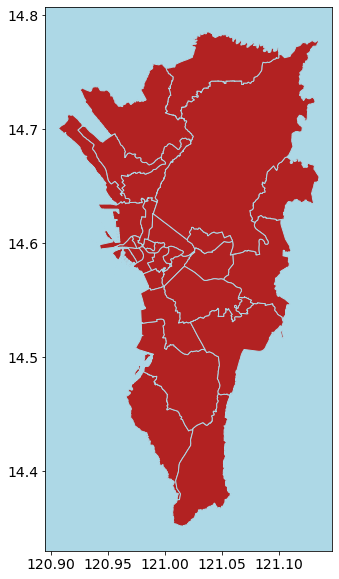

In [305]:
fig, ax = plt.subplots(figsize = (10,10))
AOI.plot(ax = ax, edgecolor = 'lightblue', color='FireBrick')
ax.set_facecolor('lightblue')
plt.savefig('PLOTS/AOI.jpg',  bbox_inches='tight')

Read barangay level population data on OSM building footprints (*takes long*):

In [47]:
building_pop = gpd.read_file('DATA/MetroManila_PopDensity/Buildings_Brgy.shp')

In [48]:
building_pop.head()

,munname,bgyname,Bgy_Popula,PopDen_Bgy,AREA_GEO,geometry
0,CALOOCAN CITY,Barangay 1,2417,0.153415,15754.633917,"MULTIPOLYGON Z (((120.97341 14.65761 0.00000, ..."
1,CALOOCAN CITY,Barangay 2,5134,0.177915,28856.442389,"MULTIPOLYGON Z (((120.97106 14.65980 0.00000, ..."
2,CALOOCAN CITY,Barangay 3,2621,0.107641,24349.558870,"MULTIPOLYGON Z (((120.97276 14.65780 0.00000, ..."
3,CALOOCAN CITY,Barangay 4,2809,0.166453,16875.591804,"MULTIPOLYGON Z (((120.97047 14.65820 0.00000, ..."
4,CALOOCAN CITY,Barangay 5,3004,0.125106,24011.726009,"MULTIPOLYGON Z (((120.97199 14.65525 0.00000, ..."


Make a plot of the population data using the OSM footprint (**takes very long**):

*To activate, run followingt chunk as code*

Map to metric projection (*also takes long, but is necessary*):

In [50]:
building_pop_p = building_pop.to_crs(proj_crs)

**Define grid**

In [306]:
grid_p = gpd.GeoDataFrame(geometry = gna.make_fishnet(AOI_p, 500))

Number of cols 56 . Number of rows 102


Determine population per grid cell:

In [307]:
reload(gna)

<module 'GostnetAddons' from 'C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOSTnetAddons\\GostnetAddons.py'>

Take the actual building level data and run calculations:

... or alternatively **load the result from previous runs of this code:**

In [308]:
grid = gpd.read_file('DATA/Manila_Gridded_Population/manila_gridded_pop.shp')
grid_p = grid.to_crs(proj_crs)

Get an overview of the population density and save:

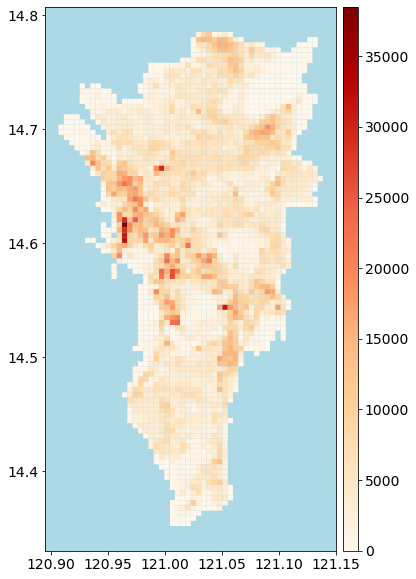

In [309]:
fig, ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_build',  legend = True,  cmap='OrRd', cax = cax)
plt.savefig('PLOTS/Grid_Pop.jpg',  bbox_inches='tight')

Check whether gridded aggregates agree with non gridded aggregates:

The aggreation method deviates by less than 0.01% -> good!

Store the result (not necessary anymore in later iterations of the code)

Total population:

In [310]:
grid_p['Pop_build'].sum()

12876810.4886881

Calculate relative population:

In [311]:
grid_p['Pop_rel'] = grid_p['Pop_build']/grid_p['Pop_build'].sum()

#### Project all school and health facility data into the correct projection:

In [315]:
mani_hos_p = mani_hos.to_crs(proj_crs)
mani_sch_p = mani_sch.to_crs(proj_crs)

## Prepare inverse distance weighting for schools

Generate a copy of the school data set to store results:

In [317]:
# Generate a copied school data set:
mani_sch_p_demand = mani_sch_p.loc[:,['objectid', 'schoolid', 'schoolname', 'division', 'district','offering', 'eligible', 'geometry']].copy()

### Add columns for population in school age, primary school age and high school age:

1. Based on **UN DESA** Population estimates for 2020 the age structure in the Philippines is the following:

| Group | Percentage of total population |
| --- | --- |
| School age (6-18) | 25.91% |
| Elementary school age (6-12) | 12.3 % |
| Secondary school age (13-18) | 13.6 % |


2. With respect to the **2015 census** the age structure is the following in the Metro Manila area

Source: [https://www.citypopulation.de/en/philippines/admin/13__metro_manila/](https://www.citypopulation.de/en/philippines/admin/13__metro_manila/)

*Unfortuantely I was unable to find a more detailed population overview by age group - even though I believe they should be included in the 2015 census, but tables were not available*

| Group | Percentage of total population |
| --- | --- |
| School age (6-18) | 24.04 % |
| Elementary school age (6-12) | 12.91 % |
| Secondary school age (13-18) | 11.13 % |

3. Combining the **April 2020 PSA quickstats** which inform about actual school enrollment in 2018 with total population estimates for 2018, the percentage school enrollment per school type is the following:

Source: 
- [Quickstat April 2020](https://psa.gov.ph/statistics/quickstat/national-quickstat/all/*) 
- [Total population estimates](https://psa.gov.ph/sites/default/files/attachments/hsd/pressrelease/Table4_9.pdf)


| Group | Percentage of total population |
| --- | --- |
| School enrollment | 23.07 % |
| Elementary school enrollment | 12.44 % |
| Secondary school enrollment | 10.64 % |

Let's use the last estimate for the remaining calculations:

In [318]:
grid_p['Pop_school'] = grid_p['Pop_build'] * 0.2307
grid_p['Pop_elem_school'] = grid_p['Pop_build'] * 0.1244
grid_p['Pop_seco_school'] = grid_p['Pop_build'] * 0.1064

To perform IDW, we need point data frames $\rightarrow$ generate a copy of the grid, based on centroids:

In [319]:
grid_p_cent = grid_p.copy()
grid_p_cent['geometry']= grid_p_cent.centroid

First, lets get an idea for the average ratio of pupils per school:

In [320]:
#Overall Population:
grid_p_cent['Pop_build'].sum()

12876810.4886881

In [321]:
print('Potential pupils in Manila:', round(grid_p_cent['Pop_school'].sum()))
print('Number of schools:', len(mani_sch_p))
print('Pupils per school:', round(grid_p_cent['Pop_school'].sum()/len(mani_sch_p)))

Potential pupils in Manila: 2970680.0
Number of schools: 768
Pupils per school: 3868.0


This indicates that on average, each school would need to host more than 3800 pupils! 
Potential error sources:
- not all schools in data set
- age structure / school enrollment in Manila is very different from the remaining Philippines

#### Start with IDW mapping of all schools 
(modelling demand indepent of a school being elementary school or high school)

In [324]:
# p=1
#5 NN within 10 km
%time mani_sch_p_demand['dist:10_k:5_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 5)

#10 NN within 10 km
%time mani_sch_p_demand['dist:10_k:10_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 10)

#All NN within 10 km
%time mani_sch_p_demand['dist:10_k:inf_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = len(mani_sch_p_demand))


# p= 0
#5 NN within 10 km
%time mani_sch_p_demand['dist:10_k:5_p:0'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 5, p = 0)

#10 NN within 10 km
%time mani_sch_p_demand['dist:10_k:10_p:0'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 10, p = 0)

#All NN within 10 km
%time mani_sch_p_demand['dist:10_k:inf_p:0'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = len(mani_sch_p_demand), p = 0)


# p= 2
#5 NN within 10 km
%time mani_sch_p_demand['dist:10_k:5_p:2'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 5, p = 2)

#10 NN within 10 km
%time mani_sch_p_demand['dist:10_k:10_p:2'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = 10, p = 2)

#All NN within 10 km
%time mani_sch_p_demand['dist:10_k:inf_p:2'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 10000 , k = len(mani_sch_p_demand), p = 2)


# p= 1
#NN only, no distance disthold
%time mani_sch_p_demand['dist:inf_k:1_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres= np.inf, k = 1, p = 1)

#All NN within 2 km
%time mani_sch_p_demand['dist:2_k:5_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 2000 , k = len(mani_sch_p_demand), p = 1)

#5 NN within 5 km
%time mani_sch_p_demand['dist:5_k:5_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_school', mani_sch_p_demand, dist_thres = 5000 , k = len(mani_sch_p_demand), p = 1)

0  values were mapped to their single nearest neighbor

Wall time: 8.44 s
0  values were mapped to their single nearest neighbor

Wall time: 7.75 s
0  values were mapped to their single nearest neighbor

Wall time: 36.2 s
0  values were mapped to their single nearest neighbor

Wall time: 7.64 s
0  values were mapped to their single nearest neighbor

Wall time: 7.6 s
0  values were mapped to their single nearest neighbor

Wall time: 37.1 s
0  values were mapped to their single nearest neighbor

Wall time: 7.4 s
0  values were mapped to their single nearest neighbor

Wall time: 7.63 s
0  values were mapped to their single nearest neighbor

Wall time: 40.3 s
0  values were mapped to their single nearest neighbor

Wall time: 9.02 s
55  values were mapped to their single nearest neighbor

Wall time: 40.9 s
0  values were mapped to their single nearest neighbor

Wall time: 35.7 s


Check if all mappings result in the same population totals:

In [325]:
mani_sch_p_demand.sum()

objectid                                                       4514119
schoolid                                                     150506201
schoolname           E delos Santos Elementary SchoolEulogio Rodrig...
division             ManilaManilaManilaManilaManilaManilaManilaMani...
district             SingalongSta. Ana ISan AndresMalatePaco ITondo...
offering             ESSSESSSSSSSESSSESESSSESESESESESSSESSSESSSESSS...
eligible                                                           461
dist:10_k:5_p:1                                            2.97068e+06
dist:10_k:10_p:1                                           2.97068e+06
dist:10_k:inf_p:1                                          2.97068e+06
dist:10_k:5_p:0                                            2.97068e+06
dist:10_k:10_p:0                                           2.97068e+06
dist:10_k:inf_p:0                                          2.97068e+06
dist:10_k:5_p:2                                            2.97068e+06
dist:1

And let's analyse the different distributions of pupils per school:

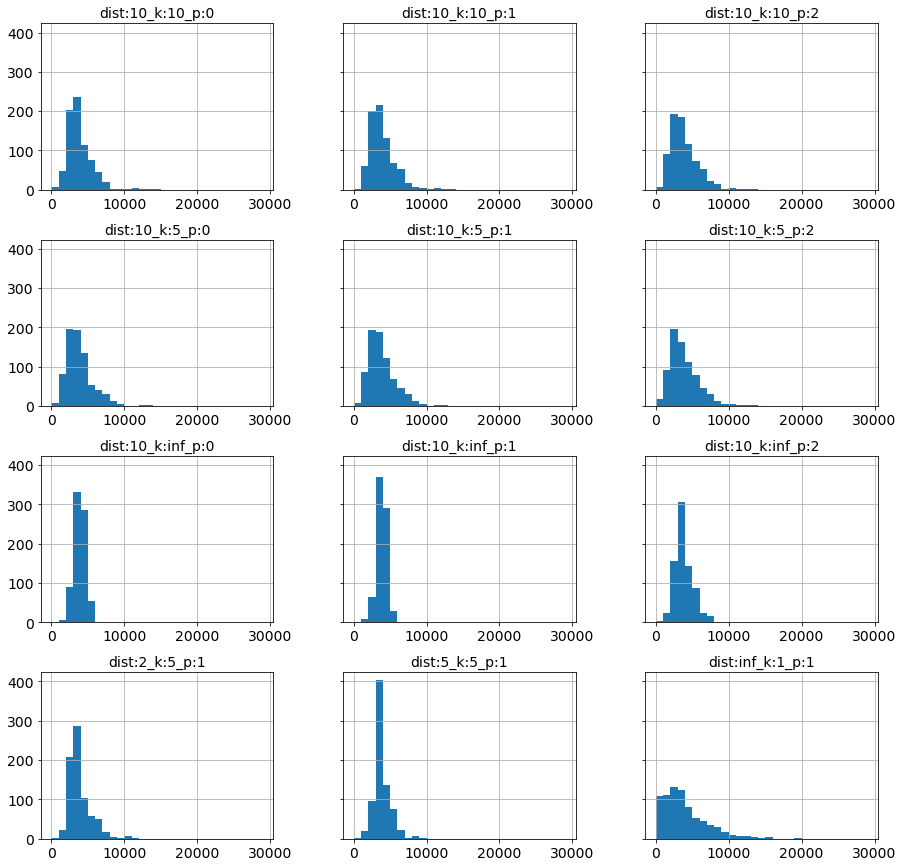

In [326]:
mani_sch_p_demand.iloc[:,-12:].hist(bins = np.arange(0,30000,1000), figsize = (15,15), sharey = True)
plt.savefig('PLOTS/School_size_hists.jpg', bbox_inches='tight')

Get a visual impression of population density and school location & demand:

In [327]:
grid_p['Pop_school'] = grid_p_cent['Pop_school']

In [328]:
import mapclassify

def pretty_fisherjenks(y, k = 5, digits = 2):
    """
    Return pretty, rounded, Fisher Jenks classification schemes. Relies on mapcalssify. 
    -----------
    Parameters:
    y: input vector
    k: number of classes
    digits: degree of rounding
    -----------
    Returns: mapclassify object
    """
    original = mapclassify.FisherJenks(y, k = k)
    accuracies = (-(np.floor(np.log10(original.bins))-digits)).astype(int)
    pretty_bins = [round(limit, accuracies[i]) for i, limit in enumerate(original.bins)]
    return mapclassify.UserDefined(y, pretty_bins)

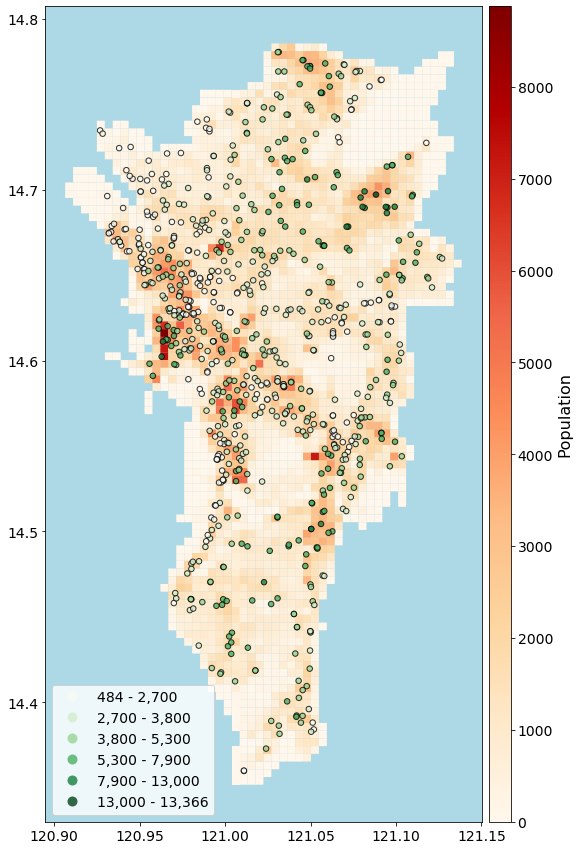

In [329]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_school',  legend = True,  cmap='OrRd', cax = cax, legend_kwds = dict(label = 'Population'))
mani_sch_p_demand.to_crs(lonlat_crs).plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                          scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_sch_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                          alpha = 0.8, markersize = 30, legend = True, edgecolor = 'black')

leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

plt.savefig('PLOTS/School_size_map_total.jpg', bbox_inches = 'tight')

Select only selected schools:

C:\WBG\Anaconda3\envs\conn\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\WBG\Anaconda3\envs\conn\lib\site-packages\mapclassify\classifiers.py:320: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\WBG\Anaconda3\envs\conn\lib\site-packages\mapclassify\classifiers.py:320: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


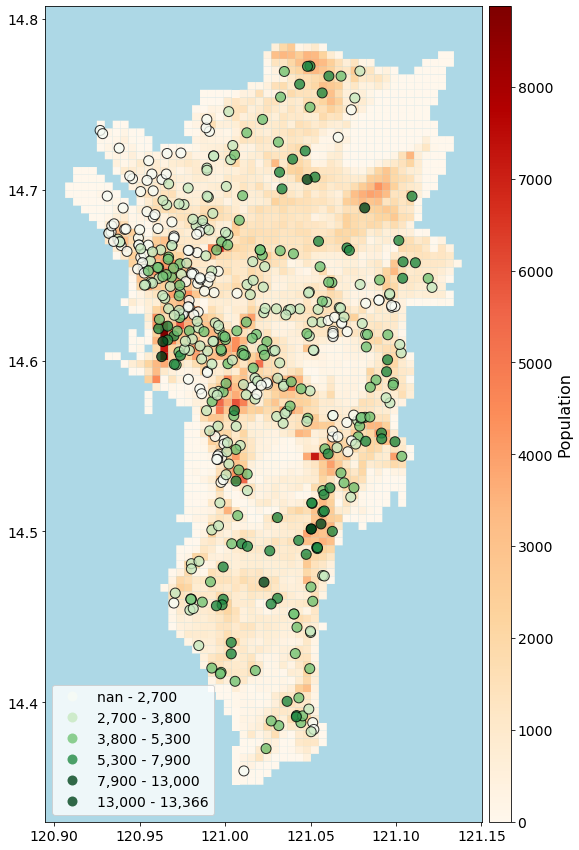

In [334]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_school',  legend = True,  cmap='OrRd', cax = cax, legend_kwds = dict(label = 'Population'))
mani_sch_p_demand.to_crs(lonlat_crs).loc[selected_school_indices,:].plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                                                         scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_sch_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                                                         alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black')


leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

plt.savefig('PLOTS/School_size_map_selected.jpg', bbox_inches = 'tight')

**Restrict the IDW to Elementary Schools only:**

In [335]:
mani_es_p_demand = mani_sch_p_demand.loc[mani_sch_p_demand['offering']=='ES'].iloc[:,:8]

In [336]:
mani_es_p_demand.head()

,objectid,schoolid,schoolname,division,district,offering,eligible,geometry
0,5455,136476,E delos Santos Elementary School,Manila,Singalong,ES,True,POINT (499034.631 1612066.533)
2,5457,136479,Rafael Palma Elementary School,Manila,San Andres,ES,True,POINT (500400.526 1611142.792)
6,5461,136477,Aurora A Quezon Elementary School,Manila,Malate,ES,True,POINT (498681.828 1611471.640)
8,5463,136474,Dr Celedonio A Salvador Elementary School,Manila,Paco II,ES,True,POINT (499455.519 1612722.066)
9,5464,136473,Justo Lukban Elementary School,Manila,Paco I,ES,True,POINT (499128.324 1612632.510)


Run algorithm with 10 NN in 10 km radius on population in elementary school age:

In [338]:
mani_es_p_demand['dist:10_k:10_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_elem_school', mani_es_p_demand, dist_thres = 10000 , k = 10)

0  values were mapped to their single nearest neighbor



**Restrict the IDW to Secondary Schools only:**

In [339]:
mani_ss_p_demand = mani_sch_p_demand.loc[mani_sch_p_demand['offering']=='SS'].iloc[:,:8]

Run algorithm with 10 NN in 10 km radius on population in secondary school age:

In [340]:
mani_ss_p_demand['dist:10_k:10_p:1'] =  gna.inverse_weighting(grid_p_cent, 'Pop_seco_school', mani_ss_p_demand, dist_thres = 10000 , k = 10)

0  values were mapped to their single nearest neighbor



### Plot:

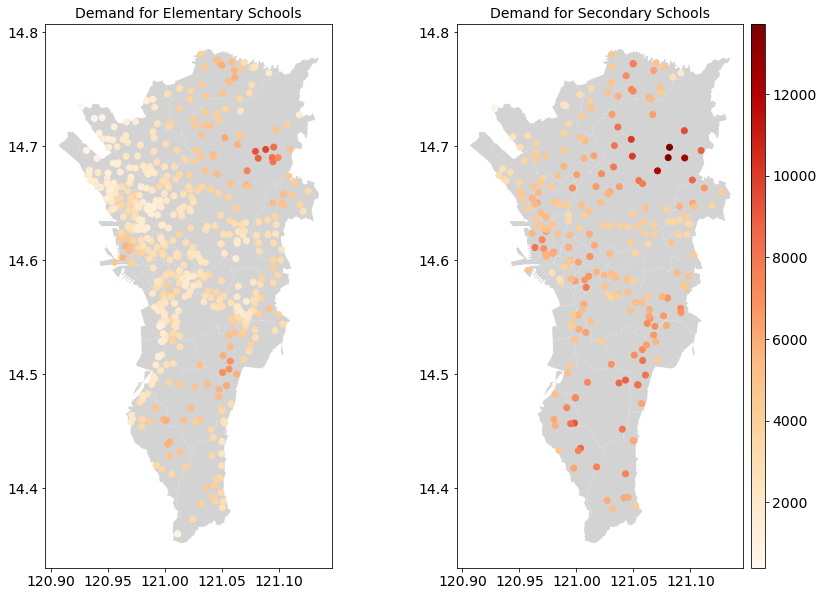

In [341]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,10), gridspec_kw={'width_ratios': [3, 3]})

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)

#ax1.set_facecolor('lightblue')
#ax2.set_facecolor('lightblue')


vmin = min([min(mani_es_p_demand['dist:10_k:10_p:1']), min(mani_ss_p_demand['dist:10_k:10_p:1'])])
vmax = max([max(mani_es_p_demand['dist:10_k:10_p:1']), max(mani_ss_p_demand['dist:10_k:10_p:1'])])

AOI.plot(ax = ax1, color = 'lightgrey')
AOI.plot(ax = ax2, color = 'lightgrey')

mani_es_p_demand.sort_values(by = 'dist:10_k:10_p:1', ascending = False).to_crs(lonlat_crs).plot(column = 'dist:10_k:10_p:1', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'OrRd')
mani_ss_p_demand.sort_values(by = 'dist:10_k:10_p:1', ascending = False).to_crs(lonlat_crs).plot(column = 'dist:10_k:10_p:1', ax = ax2, legend = True, cax = cax, vmin = vmin, vmax = vmax, cmap = 'OrRd')
ax1.title.set_text('Demand for Elementary Schools')
ax2.title.set_text('Demand for Secondary Schools')
plt.subplots_adjust(right = 1.2)
plt.show()

Distribution of ES or SS demands:

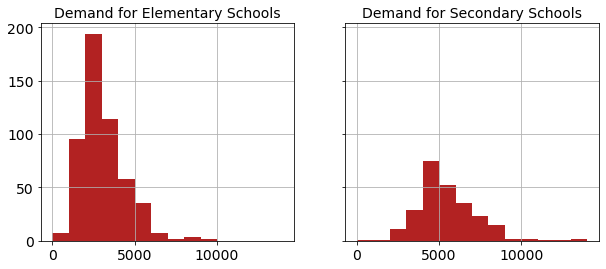

In [342]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4),  sharey = 'all')
mani_es_p_demand['dist:10_k:10_p:1'].hist(ax = ax1, bins = np.arange(0,15000, 1000), color = 'firebrick')
mani_ss_p_demand['dist:10_k:10_p:1'].hist(ax = ax2, bins = np.arange(0,15000, 1000), color = 'firebrick')
ax1.title.set_text('Demand for Elementary Schools')
ax2.title.set_text('Demand for Secondary Schools')
plt.show()

**Combine data sets:**

In [343]:
mani_school_demand_p = pd.concat([mani_es_p_demand, mani_ss_p_demand])

In [344]:
mani_school_demand_p = mani_school_demand_p.rename(columns = {'dist:10_k:10_p:1': 'demand'})

In [345]:
mani_school_demand_p = mani_school_demand_p.sort_index()

In [346]:
mani_school_demand_p['demand'].sum()

2971967.8607892133

**Add column with demand to the original, selected school, data frame:**

In [373]:
temp_1 = mani_school_demand_p.loc[list(selec_sch_com['matched_index'].values),:].drop(columns = ['geometry', 'eligible']).reset_index(drop = True)

In [381]:
temp_2 = selec_sch_com
final_school = pd.concat([temp_2, temp_1], axis = 1)

In [384]:
final_school['demand_per_building'] = final_school['demand']/final_school['FacilityBuildingCount']

Check if demands sum up to the same totals:

In [391]:
print('Total demand in selected school data frame:', final_school['demand_per_building'].sum())
print('Total demand in total school data frame:', mani_school_demand_p.loc[mani_school_demand_p['eligible'],'demand'].sum())

Total demand in selected school data frame: 1672081.6227101602
Total demand in total school data frame: 1672081.6227101602


Store results:

In [401]:
#Eligible schools
final_school.drop(columns = 'geometry').to_csv('RESULTS_NEW/eligible_schools.csv')

In [405]:
#All schools
mani_school_demand_p['Lat_X']=mani_school_demand_p.to_crs(lonlat_crs).geometry.x
mani_school_demand_p['Lat_Y']=mani_school_demand_p.to_crs(lonlat_crs).geometry.y

mani_school_demand_p.drop(columns = 'geometry').to_csv('RESULTS_NEW/all_schools.csv')

### Back of the envelope calculation for beneficiaries of upgrades over lifetime of buildings

Years spend in elementary school: 6-12, i.e. 7 years, hence every year 1/7 of students are replaced. Over a 30 year building lifetime the upgrade will hence benefit $(1 + \frac{30}{7}) * \text{number of elementary pupils}$, i.e.

In [417]:
#direct beneficiaries:
es_direct_benificaries = mani_school_demand_p.loc[(mani_school_demand_p['offering']=='ES') &(mani_school_demand_p['eligible']==True),'demand'].sum()

#indirect / lifetime benificiaries:
es_indirect_benificaries = es_direct_benificaries*(1+30/7)

print('Eligible elementary schools:', mani_school_demand_p.loc[mani_school_demand_p['offering']=='ES', 'eligible'].sum())
print('Percentage eligible elementary schools:', round(mani_school_demand_p.loc[mani_school_demand_p['offering']=='ES', 'eligible'].mean()*100, 0), '%')

print('Direct beneficaries ES investment:', round(es_direct_benificaries), '(',round(es_direct_benificaries/grid_p['Pop_elem_school'].sum()*100,0),'%)')
print('Indirect / lifetime beneficaries ES investment:', round(es_indirect_benificaries))

Eligible elementary schools: 325
Percentage eligible elementary schools: 63.0 %
Direct beneficaries ES investment: 953991.0 ( 60.0 %)
Indirect / lifetime beneficaries ES investment: 5042526.0


Years spend in secondary school: 13-18, i.e. 6 years, hence every year 1/6 of students are replaced. Over a 30 year building lifetime the upgrade will hence benefit $(1 + \frac{30}{6}) * \text{number of secondary school pupils}$, i.e.

In [418]:
#direct beneficiaries:
ss_direct_benificaries = mani_school_demand_p.loc[(mani_school_demand_p['offering']=='SS') &
                        (mani_school_demand_p['eligible']==True),'demand'].sum()

#indirect / lifetime benificiaries:
ss_indirect_benificaries = ss_direct_benificaries*(1+30/6)

print('Eligible secondary schools:', mani_school_demand_p.loc[mani_school_demand_p['offering']=='SS', 'eligible'].sum())
print('Percentage eligible secondary schools:', round(mani_school_demand_p.loc[mani_school_demand_p['offering']=='SS', 'eligible'].mean()*100, 0), '%')

print('Direct beneficaries SS investment:', round(ss_direct_benificaries),  '(',round(ss_direct_benificaries/grid_p['Pop_seco_school'].sum()*100,1),'%)')
print('Indirect / lifetime beneficaries SS investment:', round(ss_indirect_benificaries))

Eligible secondary schools: 136
Percentage eligible secondary schools: 54.0 %
Direct beneficaries SS investment: 718090.0 ( 52.4 %)
Indirect / lifetime beneficaries SS investment: 4308541.0


**Plot**

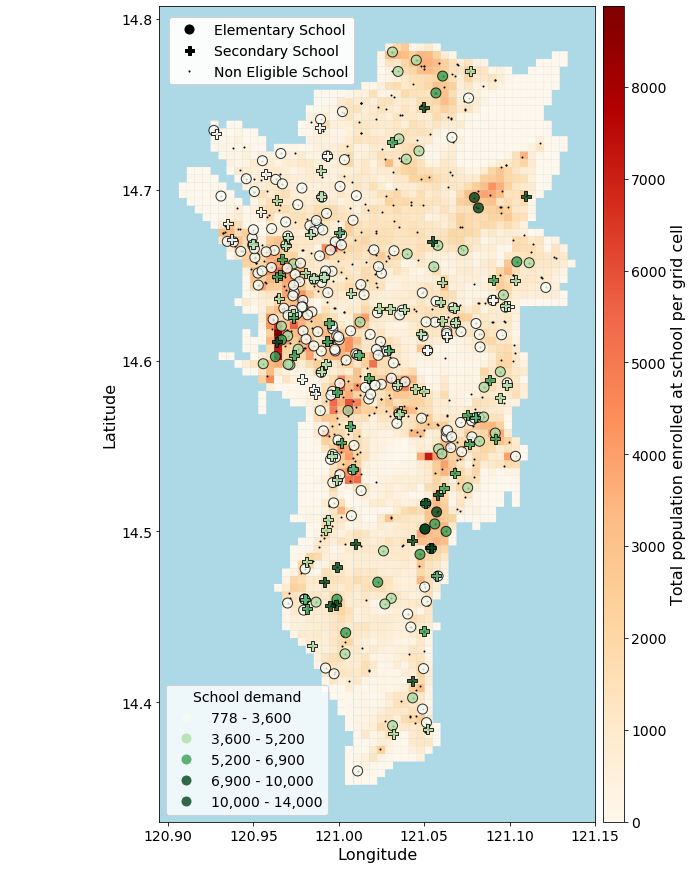

In [202]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_school',  legend = True,  cmap='OrRd', cax = cax, legend_kwds={'label':'Total population enrolled at school per grid cell'})
mani_school_demand_p.to_crs(lonlat_crs).plot(ax = ax, markersize = 1, color = 'black')
mani_es_p_demand[mani_es_p_demand['selected']].to_crs(lonlat_crs).plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                                                       scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_ss_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                                                       alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black')

mani_ss_p_demand[mani_ss_p_demand['selected']].to_crs(lonlat_crs).plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                                                       scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_ss_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                                                       alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black', marker = 'P',
                                                                      legend_kwds ={'title':'School demand'})

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker = 'o', markerfacecolor='black', color = 'None', markersize = 9),
                   Line2D([0], [0], marker='P', markerfacecolor='black',color = 'None',  markersize = 9),
                   Line2D([0], [0], marker='.', markerfacecolor='black',color = 'None', markersize = 2)]

legend2 =  fig.legend(legend_elements, ['Elementary School', 'Secondary School', 'Non Eligible School'],
                     loc='lower left', bbox_to_anchor=(0.15, .72)) 
fig.add_artist(legend2)
    
plt.savefig('PLOTS/School_size_map_combn.jpg', bbox_inches = 'tight')

In [ ]:
legend_elements = [Line2D([0], [0], marker = 'o', color='b', label='Eligible Elementary School'),
                   Line2D([0], [0], marker='P', color='b', label='Eligible Secondary School',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='.', color='b', label='Non eligible schools',
                          markerfacecolor='g', markersize=15)]

legend2 =  plt.legend(legend_elements, loc = 'upper right') 
plt.gca().add_artist(legend2)

## Prepare inverse distance weighting for hospitals:

Given the data set of health care facilities and the population data we can expect the following averages:

In [419]:
print('Population in Manila:', round(grid_p_cent['Pop_build'].sum()))
print('Number of health care facilities:', len(mani_hos_p))
print('Persons per health care facility:', round(grid_p_cent['Pop_build'].sum()/len(mani_hos_p)))

Population in Manila: 12876810.0
Number of health care facilities: 734
Persons per health care facility: 17543.0


Lets start by doing **unspecific distribution**, i.e. distribute the entire population on *all* health care facilities, independent of their type. Later we can start to distinguish by hospitals, care centers, etc

In [421]:
# New data frame to store results:
mani_hos_p_demand = mani_hos_p[['facilityn', 'healthf1', 'ownership', 'ownership1','bedcapacit','eligible','geometry']].copy()

In [422]:
#Calculate distribution for the following values:
dist_thres_l = [np.inf, 10, 5]
k_l = [5, 10]
p_l = [0, 1,2]

In [423]:
print(len(dist_thres_l)*len(k_l)*len(p_l), 'combinations of dist_thres, k, and p will be used for mapping')

18 combinations of dist_thres, k, and p will be used for mapping


In [424]:
for dist_thres in dist_thres_l:
    for k in k_l:
        for p in p_l:
            %time mani_hos_p_demand['dist:' + str(dist_thres) + '_k:' + str(k) + '_p:' + str(p)] = gna.inverse_weighting(grid_p_cent, 'Pop_build', mani_hos_p,  dist_thres*1000, k, p)

0  values were mapped to their single nearest neighbor

Wall time: 7.65 s
0  values were mapped to their single nearest neighbor

Wall time: 8 s
0  values were mapped to their single nearest neighbor

Wall time: 7.94 s
0  values were mapped to their single nearest neighbor

Wall time: 9.49 s
0  values were mapped to their single nearest neighbor

Wall time: 9.13 s
0  values were mapped to their single nearest neighbor

Wall time: 8.22 s
0  values were mapped to their single nearest neighbor

Wall time: 7.95 s
0  values were mapped to their single nearest neighbor

Wall time: 8.19 s
0  values were mapped to their single nearest neighbor

Wall time: 7.78 s
0  values were mapped to their single nearest neighbor

Wall time: 8.25 s
0  values were mapped to their single nearest neighbor

Wall time: 7.94 s
0  values were mapped to their single nearest neighbor

Wall time: 7.95 s
0  values were mapped to their single nearest neighbor

Wall time: 8.25 s
0  values were mapped to their single nea

Compare distributions of population per hospital for different inverse distance weighting methods:

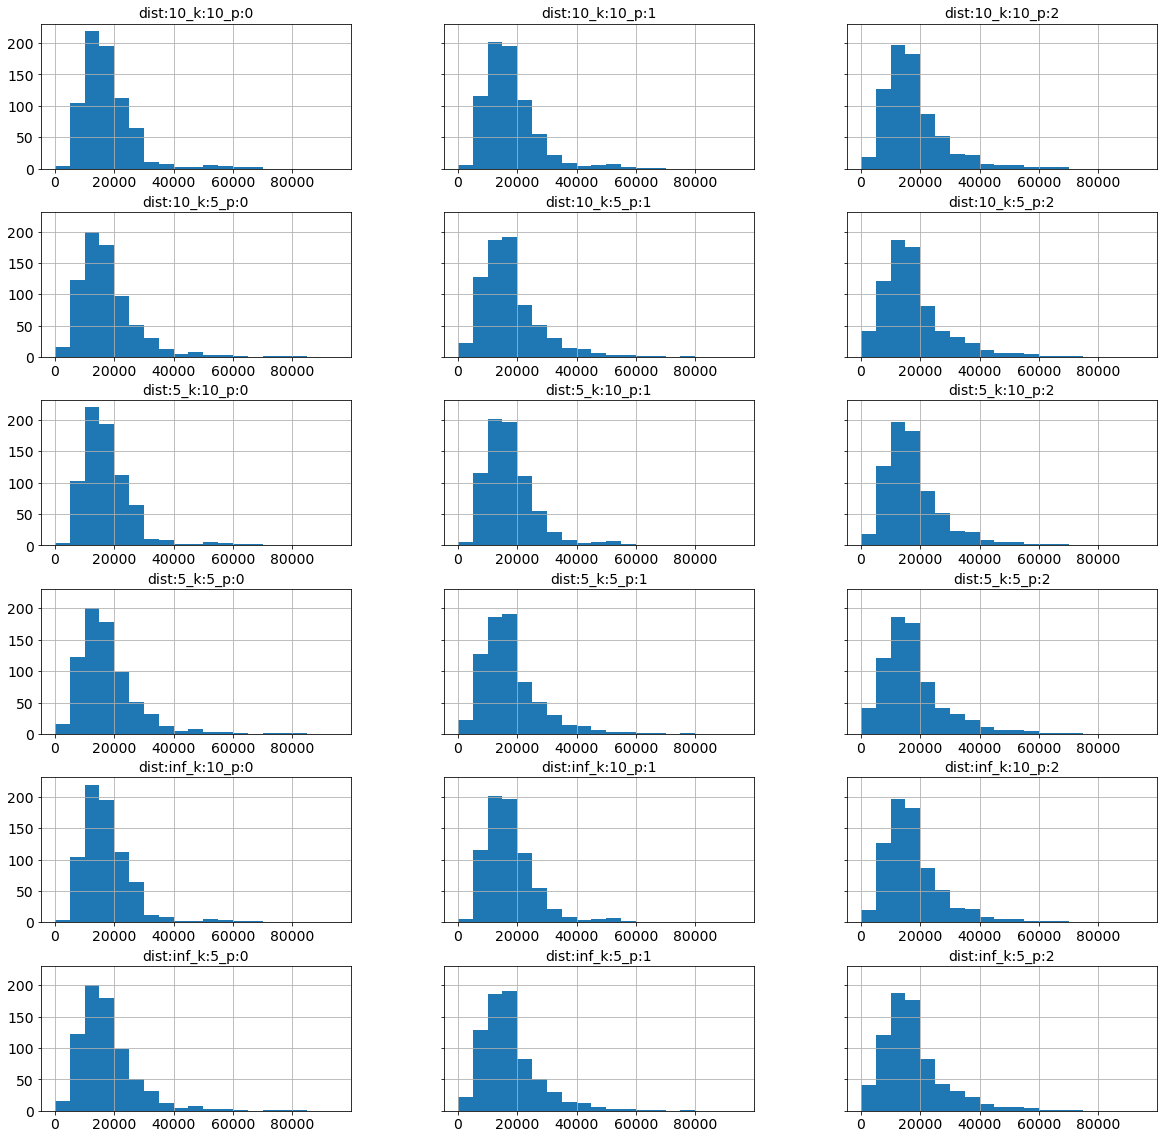

In [425]:
mani_hos_p_demand.iloc[:,-(len(dist_thres_l)*len(k_l)*len(p_l)):].hist(figsize = (20,20), sharey = True, bins = np.arange(0,100000,5000), layout = (6,3))
plt.savefig('PLOTS/Hospital_size_hists.jpg', bbox_inches='tight')

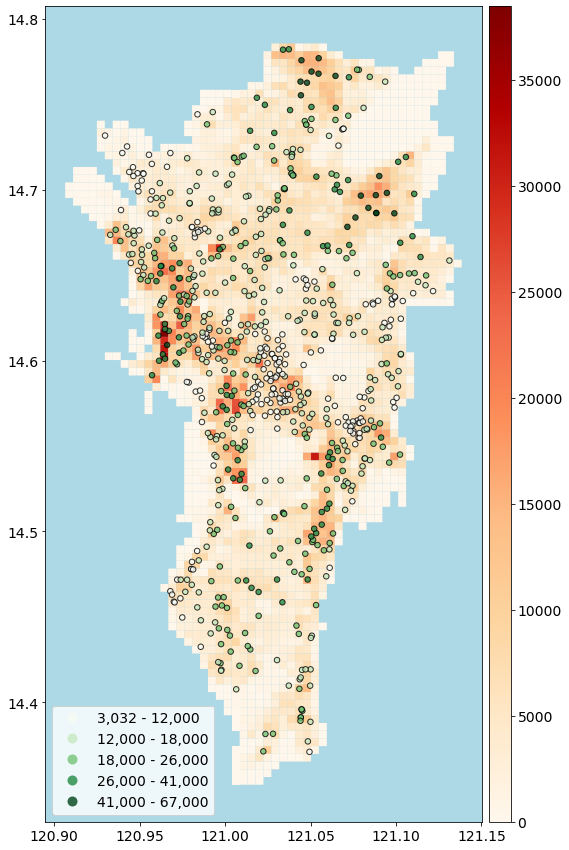

In [426]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_build',  legend = True,  cmap='OrRd', cax = cax)
mani_hos_p_demand.to_crs(lonlat_crs).plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                          scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_hos_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                          alpha = 0.8, markersize = 30, legend = True, edgecolor = 'black')

leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)
    
plt.savefig('PLOTS/Hospital_size_map_total.jpg', bbox_inches = 'tight')

In [207]:
## only for selected hospitals:

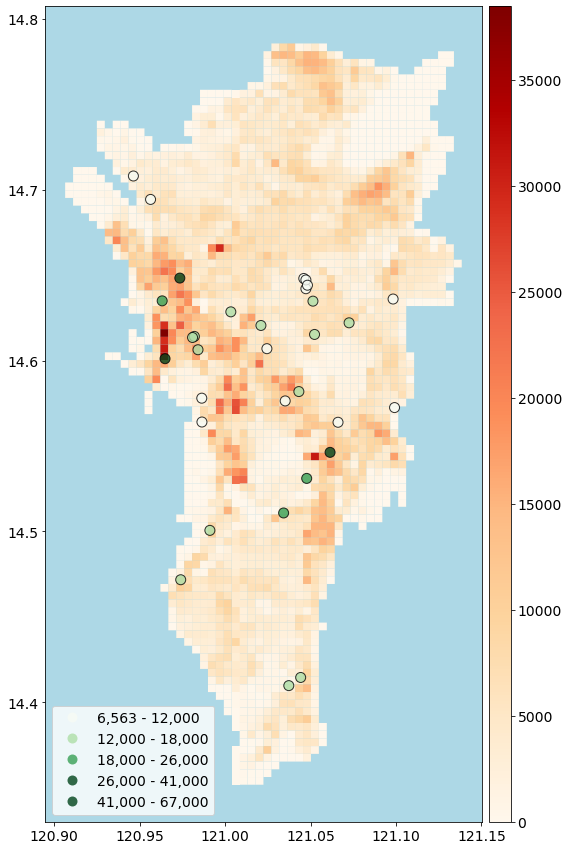

In [427]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_build',  legend = True,  cmap='OrRd', cax = cax)
mani_hos_p_demand[mani_hos_p_demand['eligible']].to_crs(lonlat_crs).plot(ax = ax, column = 'dist:10_k:10_p:1', cmap = 'Greens',
                                                                         scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_hos_p_demand['dist:10_k:10_p:1'], k = 5, digits= 1).bins),
                                                                         alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black')
leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

plt.savefig('PLOTS/Hospital_size_map_selected.jpg', bbox_inches = 'tight')

Do weighting for different hospital types independently. (For an overview of the Philippine health care system, see: [Review](https://apps.searo.who.int/PDS_DOCS/B5438.pdf))


First check what types are available:

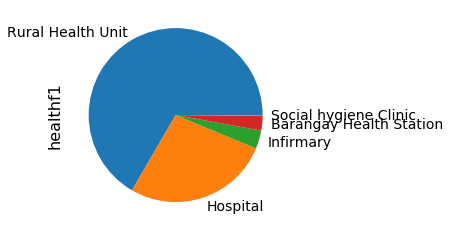

['Barangay Health Station',
 'Hospital',
 'Infirmary',
 'Rural Health Unit',
 'Social hygiene Clinic']

In [428]:
mani_hos_p['healthf1'].value_counts().plot(kind = 'pie')
plt.show()
gna.unique(mani_hos_p['healthf1'])

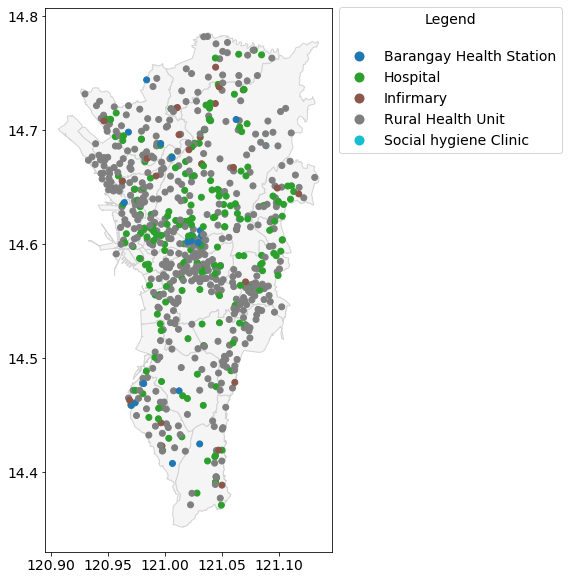

In [429]:
ax = AOI.plot(color = 'whitesmoke', figsize = (10,10), edgecolor = 'lightgrey')
mani_hos.plot(ax = ax, column = 'healthf1', legend = True, 
              legend_kwds=dict(loc='upper left', bbox_to_anchor=(1, 1.015), title="Legend\n", frameon=True, fancybox = True))
plt.show()

**Model hospitals and infirmaries separately from health stations:**

In [430]:
#Subselect data
mani_hi_p = mani_hos_p[np.isin(mani_hos_p['healthf1'], ['Hospital', 'Infirmary'])].copy()

In [432]:
#Run IDW
mani_hi_p['hospital_demand'] = gna.inverse_weighting(grid_p_cent, 'Pop_build', mani_hi_p, dist_thres = 10000, k = 10)

0  values were mapped to their single nearest neighbor



Plot the result:

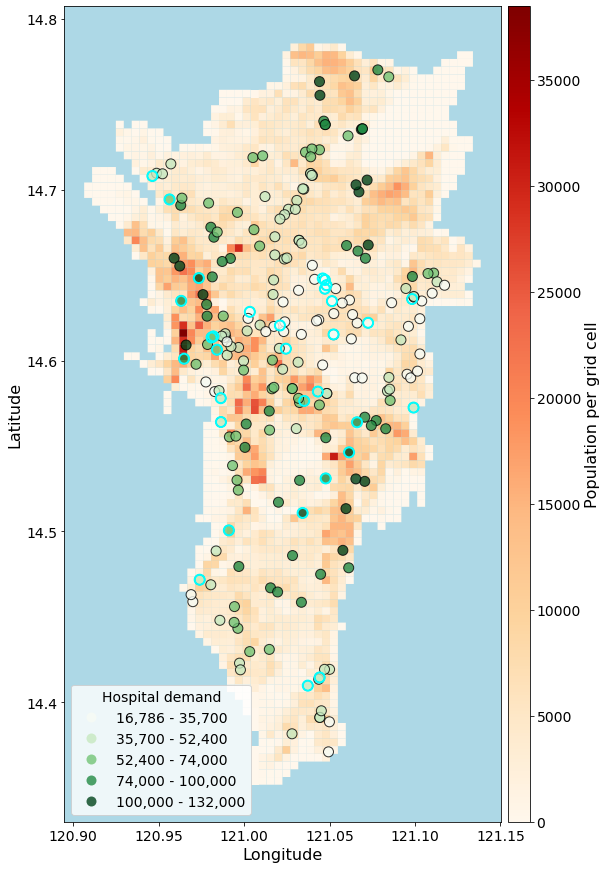

In [433]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_build',  legend = True,  cmap='OrRd', cax = cax, legend_kwds = dict(label = 'Population per grid cell'))
#Plot all hospitals:
mani_hi_p.to_crs(lonlat_crs).plot(ax = ax, column = 'hospital_demand', cmap = 'Greens',
                                  scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_hi_p['hospital_demand'], k = 5, digits= 2).bins),
                                  alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black', 
                                  legend_kwds = dict(loc='lower left', bbox_to_anchor=(0, 0), title = 'Hospital demand'))
                                 
mani_hi_p[mani_hi_p['eligible']].to_crs(lonlat_crs).plot(ax = ax, alpha = 1, marker = 'o', markersize = 100, legend = True, edgecolor = 'cyan', color = 'none', linewidth = 2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)
    
plt.savefig('PLOTS/Hospital_demand.jpg', bbox_inches = 'tight')
plt.show()

**Model rural health units and barangay health untis independently:**

In [434]:
#Subselect data
mani_rh_p = mani_hos_p[np.isin(mani_hos_p['healthf1'], ['Barangay Health Station', 'Rural Health Unit', 'Social hygiene Clinic'])].copy()

In [436]:
#Run IDW
mani_rh_p['health_center_demand'] = gna.inverse_weighting(grid_p_cent, 'Pop_build', mani_rh_p, dist_thres = 10000, k = 10)

0  values were mapped to their single nearest neighbor



Plot the result:

C:\WBG\Anaconda3\envs\conn\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


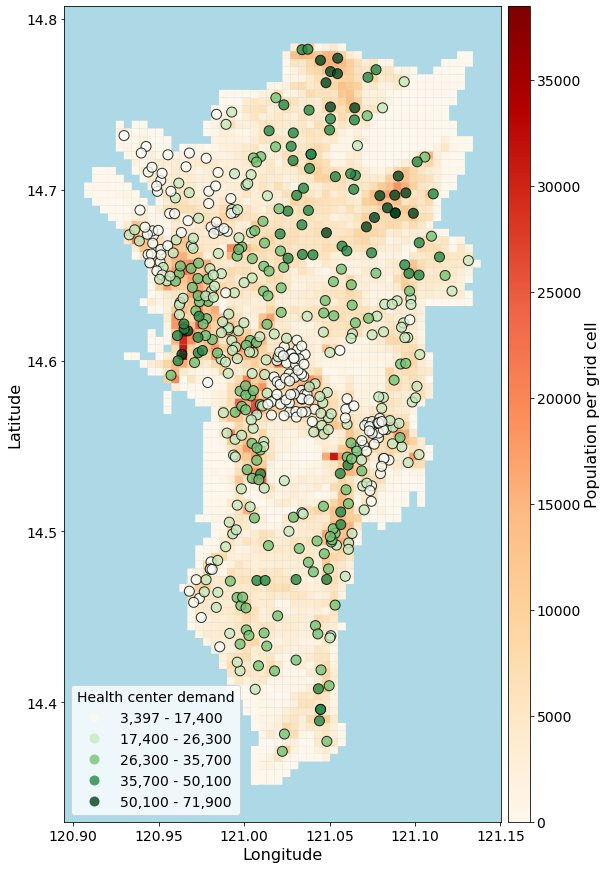

In [437]:
fig, ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_facecolor('lightblue')
grid_p.to_crs(lonlat_crs).plot(ax = ax, column = 'Pop_build',  legend = True,  cmap='OrRd', cax = cax, legend_kwds = dict(label = 'Population per grid cell'))
#Plot all hospitals:
mani_rh_p.to_crs(lonlat_crs).plot(ax = ax, column = 'health_center_demand', cmap = 'Greens',scheme="user_defined" , classification_kwds= dict(bins = pretty_fisherjenks(mani_rh_p['health_center_demand'], k = 5, digits= 2).bins),
                                  alpha = 0.8, markersize = 100, legend = True, edgecolor = 'black', legend_kwds = dict(loc='lower left', bbox_to_anchor=(0, 0), title = 'Health center demand'))
mani_rh_p[mani_rh_p['eligible']].to_crs(lonlat_crs).plot(ax = ax, alpha = 1, marker = 'o', markersize = 100, legend = True, edgecolor = 'cyan', color = 'none', linewidth = 2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

leg = ax.get_legend()
leg._loc = 3
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

plt.savefig('PLOTS/Health_center_demand.jpg', bbox_inches = 'tight')    
plt.show()

**Merge results from seperated and non differenciated modelling**

In [442]:
mani_hos_p_demand_final = mani_hos_p_demand.loc[:,['facilityn', 'healthf1','ownership', 'ownership1', 'bedcapacit', 'eligible', 'geometry', 'dist:10_k:10_p:1']].rename(columns = {'dist:10_k:10_p:1': 'demand'})
mani_hos_p_demand_final = pd.concat([mani_hos_p_demand_final, 
                                     pd.concat([mani_rh_p, mani_hi_p], sort = False).sort_index().loc[:, ['hospital_demand', 'health_center_demand']]],
                                    axis = 1)
mani_hos_p_demand_final = mani_hos_p_demand_final.drop(columns = 'demand')
mani_hos_p_demand_final.head()

,facilityn,healthf1,ownership,ownership1,bedcapacit,eligible,geometry,hospital_demand,health_center_demand
0,LIBTONG BARANGAY HEALTH STATION,Barangay Health Station,Government,Local Government Unit,None,False,POINT (498114.094 1630659.094),NaN,10989.093522
1,NODADO GENERAL HOSPITAL,Hospital,Private,None,15,False,POINT (504967.718 1629993.896),85821.407664,NaN
2,JUSTICE JOSE ABAD SANTOS GENERAL HOSPITAL,Hospital,Government,Local Government Unit,0,False,POINT (496825.914 1614475.295),56704.794271,NaN
3,MEISIC HEALTH CENTER,Rural Health Unit,Government,Local Government Unit,0,False,POINT (496967.169 1615222.095),NaN,38174.278279
4,BAMBANG BARANGAY HEALTH STATION,Barangay Health Station,Government,Local Government Unit,0,False,POINT (508272.769 1609717.592),NaN,9606.985447


**Add column with demand to the original, selected hospital, data frame:**

In [444]:
temp_1 = mani_hos_p_demand_final.loc[list(selec_hos_com['matched_index'].values),:].drop(columns = ['geometry', 'eligible']).reset_index(drop = True)

In [447]:
temp_2 = selec_hos_com
final_hospital = pd.concat([temp_2, temp_1], axis = 1)

final_hospital= final_hospital.drop(columns = 'health_center_demand')

In [448]:
final_hospital['demand_per_building'] = final_hospital['hospital_demand']/final_hospital['FacilityBuildingCount']

Check if demands sum up to the same totals:

In [451]:
print('Total demand in selected hospital data frame:', final_hospital['demand_per_building'].sum())
print('Total demand in full hospital data frame:', mani_hos_p_demand_final.loc[mani_hos_p_demand_final['eligible'],'hospital_demand'].sum())

Total demand in selected hospital data frame: 1774129.502148368
Total demand in full hospital data frame: 1774129.5021483677


Store results:

In [455]:
#Eligible schools
final_hospital.drop(columns = 'geometry').to_csv('RESULTS_NEW/eligible_hospitals.csv')

In [454]:
#All schools
mani_hos_p_demand_final['Lat_X']=mani_hos_p_demand_final.to_crs(lonlat_crs).geometry.x
mani_hos_p_demand_final['Lat_Y']=mani_hos_p_demand_final.to_crs(lonlat_crs).geometry.y

mani_hos_p_demand_final.drop(columns = 'geometry').to_csv('RESULTS_NEW/all_hospitals.csv')

### Back of the envelope calculation for beneficiaries of upgrades over lifetime of buildings

To evaluate the potential beneficiaries of the hospital upgrades we need to make some assumptions about population growth in the next decades. UN DESA makes the following population projections for the Philippines (medium growth scenario)

| Year | Population | Absolute Growth | Growth Rate |
| --- | --- | --- | --- |
|2020 |	 109,581 | | |		
|2025 |	 116,833 | 	 7,252 |	6.62%|
|2030 | 123,698 |	 6,865 | 	5.88%|
|2035|	 130,040 |	 6,342 	|5.13%|
|2040|	 135,619 | 	 5,579 |	4.29%|
|2045|	 140,438 | 	 4,819 |	3.55%|
|2050|	 144,488 |	 4,050 |	2.88%|
|2055|	 147,732 |	 3,244 |	2.25%|
|2060|	 150,220 | 	 2,488 |	1.68%|

If we assume that the population over the next 30 years benefits from the upgrades the total number of beneficaries is $\frac{144,488}{109,581} -1 = 31.85 \% $ larger than the current number of direct beneficaries:

Do modelling of hospitals and health stations seperately:

In [458]:
##Hospitals
#direct beneficiaries:
hos_direct_beneficiaries = mani_hos_p_demand_final.loc[mani_hos_p_demand_final['eligible'],'hospital_demand'].sum()

print('Direct beneficaries of hospital upgrades:', round(hos_direct_beneficiaries))
print('Percentage direct beneficaries of hospital upgrades:', round(hos_direct_beneficiaries/grid_p['Pop_build'].sum() * 100, 2), "%" )

#indirect beneficaries:
print('Indirect beneficaries of hospital upgrades:', round(hos_direct_beneficiaries*1.3185))

#Number of hospitals:
print('Number of hospitals in Manila:', len(mani_hi_p))
print('Number of eligible hospitals in Manila:', mani_hi_p['eligible'].sum(), '(',100*mani_hi_p['eligible'].sum()/ len(mani_hi_p),'%)')



Direct beneficaries of hospital upgrades: 1774130.0
Percentage direct beneficaries of hospital upgrades: 13.78 %
Indirect beneficaries of hospital upgrades: 2339190.0
Number of hospitals in Manila: 224
Number of eligible hospitals in Manila: 32 ( 14.285714285714286 %)


In [254]:
#Health centers:
#direct beneficiaries:
hec_direct_beneficiaries = mani_hos_p_demand_final.loc[mani_hos_p_demand_final['selected'],'health_center_demand'].sum()

print('Direct beneficaries of health center upgrades:', round(hec_direct_beneficiaries))
print('Percentage direct beneficaries of  health center upgrades:', round(hec_direct_beneficiaries/grid_p['Pop_build'].sum() * 100, 2), "%" )

#indirect beneficaries:
print('Indirect beneficaries of health center upgrades:', round(hec_direct_beneficiaries*1.3185))

print('Number of health centers in Manila:', len(mani_rh_p))
print('Number of eligible health centers in Manila:', mani_rh_p['selected'].sum(), '(',100*mani_rh_p['selected'].sum()/ len(mani_rh_p),'%)')


Direct beneficaries of health center upgrades: 17530.0
Percentage direct beneficaries of  health center upgrades: 0.14 %
Indirect beneficaries of health center upgrades: 23113.0
Number of health centers in Manila: 510
Number of eligible health centers in Manila: 1 ( 0.19607843137254902 %)


**Combine final data sets into one data set containing all demands**

In [276]:
selec_buil_demand = pd.concat([selec_hos_demand.rename(columns = {'demand': 'demand_health'}),selec_sch_demand.rename(columns = {'demand': 'demand_school'})], sort = False).reset_index(drop = True).sort_values('Object_ID').reset_index(drop = True)

In [277]:
selec_buil_demand.columns
selec_buil_demand.drop(columns = 'geometry').to_csv('RESULTS/1287_Eligible_Buildings_Demand.csv')
selec_buil_demand.to_file('RESULTS/1287_Eligible_Buildings_Location_Demand.shp')

**Store data set on all schools & on all health care facilities:**

In [285]:
mani_hos_p_demand_final.to_crs(lonlat_crs).to_file('RESULTS/Hospitals_demand.shp')
mani_hos_p_demand_final.drop(columns = 'geometry').to_csv('RESULTS/Hospitals_demand.csv')

In [287]:
#As shp file:
mani_school_demand_p.to_crs(lonlat_crs).to_file('RESULTS/Schools_demand.shp')
#As csv file:
mani_school_demand_p.drop(columns = 'geometry').to_csv('RESULTS/Schools_demand.csv')

# THE END